In [1]:
import json
import inspect
import matplotlib.pyplot as plt
import requests

import pandas as pd
import numpy as np

import japanize_matplotlib
plt.rcParams["font.size"] = 15


# エンドポイントの指定
endpoint_url = ""

In [2]:

def get_cost_func(context, min_value, max_value):
    import numpy as np
    global get_cost
    def get_cost(x, context):
        def _needle_in_haystack_context1(x):
            return (-np.exp(-(2*(x-0.2)**2)/(0.3**2)-1) -np.exp(-((x-0.8)**2)/(0.02**2)) + 1)

        def _needle_in_haystack_context2(x):
            return (-np.exp(-((x-0.3)**2)/(0.2**2)-1) -np.exp(-((x-0.6)**2)/(0.02**2)) + 1.05)
        if context == 1:
            return _needle_in_haystack_context1(x/100)
        if context == 2:
            return _needle_in_haystack_context2(x/100)
    
    cost_list = []
    for i in range(min_value, max_value):
        cost = get_cost(i, context=context)
        cost_list.append(cost)
    return cost_list
    

In [3]:
cost_func = inspect.getsource(get_cost_func)

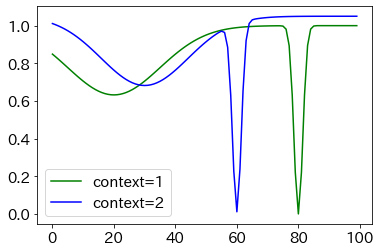

In [4]:

min_value=0
max_value=100

plt.plot(get_cost_func(context=1, min_value=min_value, max_value=max_value), label="context=1", color="g")
plt.plot(get_cost_func(context=2, min_value=min_value, max_value=max_value),  label="context=2",  color="b")
plt.legend()

In [5]:
def exploitation(context, data_dict):    
    if len(data_dict[f"costs_{context}_dict"]) !=0:
        action_classic = min(data_dict[f"costs_{context}_dict"].items(), key=lambda x: x[1])[0]
    else:
        action_classic = np.random.randint(min_value, max_value)
    if len(data_dict[f"costs_{context}_dict_quantum"]) !=0: 
        action_qiuantum = min(data_dict[f"costs_{context}_dict_quantum"].items(), key=lambda x: x[1])[0]
    else:
        action_qiuantum = np.random.randint(min_value, max_value)
    return action_classic, action_qiuantum

In [6]:
def quantum_strategy(context, y=None):    
    

    data = {
        "function":cost_func,
        "context":context,
        "min_value":min_value,
        "max_value":max_value,
        "y":y
    }
    url = endpoint_url + "/partial_dh"
    r = requests.post(url, json=data)

    action, cost, final_count =  r.json()

    return action, cost, final_count

In [ ]:
# costs_1_all = []
costs_2_all = []
actions_1_all = []
actions_2_all = []


costs_1_all_quantum = []
costs_2_all_quantum = []
actions_1_all_quantum = []
actions_2_all_quantum = []
from tqdm import tqdm

for epoch in tqdm(range(30)):
    data_dict = {"costs_1":[], "costs_2":[], "costs_1_quantum":[], "costs_2_quantum":[], 
                 "actions_1":[], "actions_2":[],"actions_1_quantum":[], "actions_2_quantum":[],
                 "costs_1_dict":{}, "costs_2_dict":{}, "costs_1_dict_quantum":{}, "costs_2_dict_quantum":{}}
    
    action_quantum_dict = {"context_1":None, "context_2":None, }

    action=None
    for num,  i in enumerate(range(400)):
        context = int(np.random.choice([1, 2]))
        epsilon = 0.1
        if np.random.rand() < epsilon: 
            action_classic = np.random.randint(min_value, max_value)
            cost = get_cost(action_classic, context)
                    
            action_quantum = action_quantum_dict[f"context_{context}"]
            
            action_quantum, cost_quantum, final_count = quantum_strategy(context, y=action_quantum)
            action_quantum_dict[f"context_{context}"] = action_quantum
        else:
            action_classic, action_quantum = exploitation(context, data_dict)
            cost = get_cost(action_classic, context)
            cost_quantum = get_cost(action_quantum, context)
            
        if context == 1:
            data_dict["costs_1"].append(cost)
            data_dict["costs_1_quantum"].append(cost_quantum)
            data_dict["actions_1"].append(action_classic)            
            data_dict["actions_1_quantum"].append(action_quantum)            
            data_dict["costs_1_dict"][action_classic] = cost
            data_dict["costs_1_dict_quantum"][action_quantum] = cost_quantum
        
        if context == 2:
            data_dict["costs_2"].append(cost)
            data_dict["costs_2_quantum"].append(cost_quantum)
            data_dict["actions_2"].append(action_classic)            
            data_dict["actions_2_quantum"].append(action_quantum)            
            data_dict["costs_2_dict"][action_classic] = cost
            data_dict["costs_2_dict_quantum"][action_quantum] = cost_quantum
           
    costs_1_all.append(data_dict["costs_1"])
    costs_1_all_quantum.append(data_dict["costs_1_quantum"])
    
    costs_2_all.append(data_dict["costs_2"])
    costs_2_all_quantum.append(data_dict["costs_2_quantum"])
    
    actions_1_all.append(data_dict["actions_1"])
    actions_1_all_quantum.append(data_dict["actions_1_quantum"])
    
    actions_2_all.append(data_dict["actions_2"])
    actions_2_all_quantum.append(data_dict["actions_2_quantum"])    

In [8]:

costs_1_mean = pd.DataFrame(costs_1_all).dropna(axis=1).mean()
costs_2_mean = pd.DataFrame(costs_2_all).dropna(axis=1).mean()
actions_1_mean = pd.DataFrame(actions_1_all).dropna(axis=1).mean()
actions_2_mean = pd.DataFrame(actions_2_all).dropna(axis=1).mean()

costs_1_mean_quantum = pd.DataFrame(costs_1_all_quantum).dropna(axis=1).mean()
costs_2_mean_quantum = pd.DataFrame(costs_2_all_quantum).dropna(axis=1).mean()
actions_1_mean_quantum = pd.DataFrame(actions_1_all_quantum).dropna(axis=1).mean()
actions_2_mean_quantum = pd.DataFrame(actions_2_all_quantum).dropna(axis=1).mean()



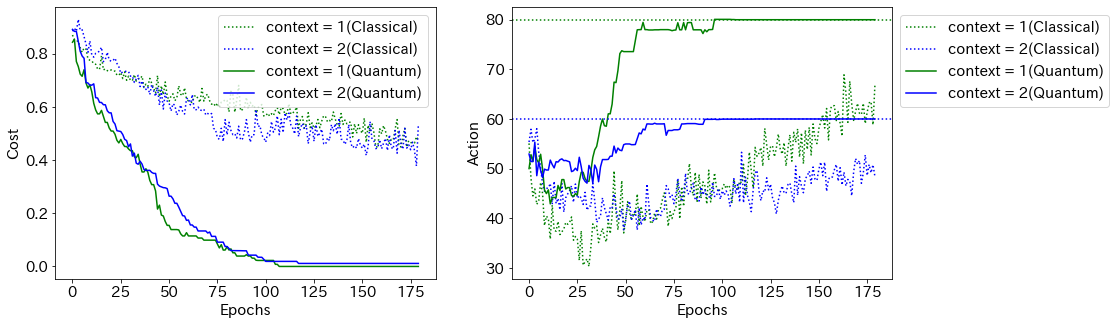

In [9]:
_, ax = plt.subplots(ncols=2, figsize=(15, 5))
ax[0].plot(costs_1_mean, "g", linestyle = "dotted", label="context = 1(Classical)")
ax[0].plot(costs_2_mean, "b", linestyle = "dotted",label="context = 2(Classical)")
ax[0].plot(costs_1_mean_quantum, "g", label="context = 1(Quantum)")
ax[0].plot(costs_2_mean_quantum, "b", label="context = 2(Quantum)")
ax[0].set_xlabel("Epochs")

ax[0].set_ylabel("Cost")
ax[0].legend()

ax[1].plot(actions_1_mean, "g", linestyle = "dotted",label="context = 1(Classical)")
ax[1].plot(actions_2_mean, "b", linestyle = "dotted",label="context = 2(Classical)")
ax[1].plot(actions_1_mean_quantum, "g", label="context = 1(Quantum)")
ax[1].plot(actions_2_mean_quantum, "b", label="context = 2(Quantum)")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Action")

ax[1].axhline(y=80, color="g", linestyle = "dotted")
ax[1].axhline(y=60, color="b", linestyle = "dotted")
ax[1].legend(bbox_to_anchor=(1, 1))

plt.show()